In [1]:
import os
import glob

import mne
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
data_dir = "/kaggle/input/ppg-dalia-processed"
filepaths = glob.glob(os.path.join(data_dir, "*.npz"))

In [3]:
# 80-20-20
train_files, test_files = train_test_split(filepaths, test_size=0.2, shuffle=True, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.5, shuffle=True, random_state=42)

In [4]:
labels = []

for file in train_files:
    labels.append(np.load(file)["label"])
    
labels = np.concatenate(labels)
mean, std = labels.mean(), labels.std()

- Dataset & Dataloader
- Training
- Evaluation

In [5]:
train_ecg = []
train_ppg = []
train_labels = []

for file in tqdm(train_files):
    data = np.load(file)
    ecg = data["ecg"]
    ppg = data["ppg"]
    label = data["label"]
    
    ecg_resampled = mne.filter.resample(ecg.astype(float), down=700/64)
    train_ecg.append(ecg_resampled)
    train_ppg.append(ppg)
    train_labels.append(label)

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
val_ecg = []
val_ppg = []
val_labels = []

for file in tqdm(val_files):
    data = np.load(file)
    ecg = data["ecg"]
    ppg = data["ppg"]
    label = data["label"]
    
    ecg_resampled = mne.filter.resample(ecg.astype(float), down=700/64)
    val_ecg.append(ecg_resampled)
    val_ppg.append(ppg)
    val_labels.append(label)

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
test_ecg = []
test_ppg = []
test_labels = []

for file in tqdm(test_files):
    data = np.load(file)
    ecg = data["ecg"]
    ppg = data["ppg"]
    label = data["label"]
    
    ecg_resampled = mne.filter.resample(ecg.astype(float), down=700/64)
    test_ecg.append(ecg_resampled)
    test_ppg.append(ppg)
    test_labels.append(label)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
train_ecg = np.concatenate(train_ecg, axis=0)
val_ecg = np.concatenate(val_ecg, axis=0)

train_ppg = np.concatenate(train_ppg, axis=0)
val_ppg = np.concatenate(val_ppg, axis=0)

train_labels = np.concatenate(train_labels, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

In [45]:
test_ecg = np.concatenate(test_ecg, axis=0)
test_ppg = np.concatenate(test_ppg, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [8]:
train_ecg = (train_ecg - np.min(train_ecg)) / (np.max(train_ecg) - np.min(train_ecg))
train_ppg = (train_ppg - np.min(train_ppg)) / (np.max(train_ppg) - np.min(train_ppg))

val_ecg = (val_ecg - np.min(val_ecg)) / (np.max(val_ecg) - np.min(val_ecg))
val_ppg = (val_ppg - np.min(val_ppg)) / (np.max(val_ppg) - np.min(val_ppg))

In [46]:
test_ecg = (test_ecg - np.min(test_ecg)) / (np.max(test_ecg) - np.min(test_ecg))
test_ppg = (test_ppg - np.min(test_ppg)) / (np.max(test_ppg) - np.min(test_ppg))

In [9]:
def normalize_labels(label):
    return (label - mean) / std

def unnormalize_labels(label):
    return std * label + mean

mean, std = train_labels.mean(), train_labels.std()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

In [11]:
train_ecg = torch.tensor(train_ecg, dtype=torch.float32)
train_ppg = torch.tensor(train_ppg, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [47]:
test_ecg = torch.tensor(test_ecg, dtype=torch.float32)
test_ppg = torch.tensor(test_ppg, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [12]:
train_ecg = train_ecg.unsqueeze(dim=-2)
train_ppg = train_ppg.unsqueeze(dim=-2)
train_labels = train_labels.unsqueeze(dim=-1)

In [54]:
test_ecg = test_ecg.unsqueeze(dim=-2)
test_ppg = test_ppg.unsqueeze(dim=-2)
test_labels = test_labels.unsqueeze(dim=-1)

In [13]:
train_labels_normalized = normalize_labels(train_labels)

In [43]:
batch_size = 128

train_dataset = TensorDataset(train_ecg, train_ppg, train_labels_normalized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 48

        self.conv0 = nn.Conv1d(1, 48, kernel_size=80, stride=4)
        self.bn1 = nn.BatchNorm1d(48)
        self.stage0 = self._make_layer(block, 48, num_blocks[0], stride=1)
        self.stage1 = self._make_layer(block, 96, num_blocks[1], stride=2)
        self.stage2 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.stage3 = self._make_layer(block, 384, num_blocks[3], stride=2)
        self.fc = nn.Linear(384*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)


    def forward(self, x):
        
        out = self.conv0(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.stage0(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = F.avg_pool1d(out, 1)
        
        features = out.mean(dim=2)
        out = self.fc(features)
        
        return out, features



def ResNet18(num_classes=2):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

def ResNet34(num_classes=2):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

def ResNet50(num_classes=2):
    return ResNet(Bottleneck, [3,4,6,3], num_classes=num_classes)

def ResNet101(num_classes=2):
    return ResNet(Bottleneck, [3,4,23,3], num_classes=num_classes)

def ResNet152(num_classes=2):
    return ResNet(Bottleneck, [3,8,36,3], num_classes=num_classes)

In [18]:
class ResBlock(nn.Module):

    def __init__(self, filters, stage, i_block, kernel_size=3, stride=1):
        super(ResBlock,self).__init__()
        self.out_channels = filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = filters

        if i_block == 0 and stage != 0:
            self.in_channels = filters // 2

        self.conv1 = nn.Conv1d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding='same')
        self.bn1 = nn.BatchNorm1d(self.out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding='same')

        self.bn2 = nn.BatchNorm1d(self.out_channels)
        self.bn3 = nn.BatchNorm1d(self.out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):

        out = x
        out = self.relu1(self.bn1(self.conv1(out)))
        out = self.bn2(self.conv2(out))
        if x.shape[1] != out.shape[1]:
            out = torch.add(out, torch.repeat_interleave(x, 2, dim=1))
        else:
            out = torch.add(out, x)

        out = self.relu2(self.bn3(out))

        return out



class Resnet34Baseline(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet34Baseline,self).__init__()
        self.num_classes = num_classes
        self.conv0 = nn.Conv1d(1, 48, 80, 4)
        self.bn0 = nn.BatchNorm1d(48)
        self.relu = nn.ReLU()
        self.pool0 = nn.MaxPool1d(4)
        self.stage0 = nn.Sequential(ResBlock(48, 0, 0),
                                   ResBlock(48, 0, 1))
        self.pool1 = nn.MaxPool1d(4)
        self.stage1 = nn.Sequential(ResBlock(96, 1, 0),
                                   ResBlock(96, 1, 1))
        self.pool2 = nn.MaxPool1d(4)
        self.stage2 = nn.Sequential(ResBlock(192, 2, 0),
                                    ResBlock(192, 2, 1))
        self.pool3 = nn.MaxPool1d(4)
        self.stage3 = nn.Sequential(ResBlock(384, 3, 0),
                                    ResBlock(384, 3, 1))

        self.avgpool = nn.AvgPool1d(1)
        self.dense1 = nn.Linear(384, self.num_classes)

    def forward(self, x, placeholder):
        
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.pool0(out)


        out = self.stage0(out)
        out = self.pool1(out)

        out = self.stage1(out)
        out = self.pool2(out)


        out = self.stage2(out)
        out = self.pool3(out)


        out = self.stage3(out)


        out = self.avgpool(out)
        features = out.mean(dim=2)

        out = self.dense1(features)

        return features, out


class Resnet34(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet34,self).__init__()
        self.num_classes = num_classes
        self.conv0 = nn.Conv1d(1, 48, 7, 2)
        self.bn0 = nn.BatchNorm1d(48)
        self.relu = nn.ReLU()
        self.pool0 = nn.MaxPool1d(2)
        self.stage0 = nn.Sequential(ResBlock(48, 0, 0),
                                   ResBlock(48, 0, 1))
        self.pool1 = nn.MaxPool1d(2)
        self.stage1 = nn.Sequential(ResBlock(96, 1, 0),
                                   ResBlock(96, 1, 1))
        self.pool2 = nn.MaxPool1d(2)
        self.stage2 = nn.Sequential(ResBlock(192, 2, 0),
                                    ResBlock(192, 2, 1))
        self.pool3 = nn.MaxPool1d(2)
        self.stage3 = nn.Sequential(ResBlock(384, 3, 0),
                                    ResBlock(384, 3, 1))

        self.avgpool = nn.AvgPool1d(1)
        self.fc = nn.Linear(384, self.num_classes)

    def forward(self, x):
        
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.pool0(out)


        out = self.stage0(out)
        out = self.pool1(out)

        out = self.stage1(out)
        out = self.pool2(out)


        out = self.stage2(out)
        out = self.pool3(out)


        out = self.stage3(out)


        out = self.avgpool(out)
        features = out.mean(dim=2)
        out = self.fc(features)

        return out, features


class DirectFwd(nn.Module):
    def __init__(self):
        super(DirectFwd, self).__init__()

    def forward(self, x):
        return x


class Res34SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, dim=2048, pred_dim=512, predictor=True):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(Res34SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = Resnet34(num_classes=dim)
        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        if predictor:
        # build a 2-layer predictor
            self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                            nn.BatchNorm1d(pred_dim),
                                            nn.ReLU(inplace=True), # hidden layer
                                            nn.Linear(pred_dim, dim)) # output layer
        else:
            self.predictor = DirectFwd()

        self.regression_head = nn.Linear(384, 2)

    def forward(self, ECG, PPG):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """
        # compute features for one view
        z1, features1 = self.encoder(ECG) # NxC
        z2, features2 = self.encoder(PPG) # NxC

        p1 = self.predictor(z1) # NxC
        p2 = self.predictor(z2) # NxC

        reg_pred1 = self.regression_head(features1)
        reg_pred2 = self.regression_head(features2)

        return p1, p2, z1.detach(), z2.detach(), reg_pred1, reg_pred2


class Res50SimSiam(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, dim=2048, pred_dim=512, predictor=True, single_source_mode=False):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(Res50SimSiam, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs
        self.encoder = ResNet50(num_classes=dim)
        self.single_source_mode = single_source_mode
        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]

        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        if predictor:
        # build a 2-layer predictor

            self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                            nn.BatchNorm1d(pred_dim),
                                            nn.ReLU(inplace=True), # hidden layer
                                            nn.Linear(pred_dim, dim)) # output layer
        else:
            self.predictor = DirectFwd()

        self.classification_head = nn.Linear(1536, 2)

    def forward(self, ECG, PPG):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """

        if not self.single_source_mode:
            # compute features for one view
            z1, features1 = self.encoder(ECG) # NxC
            z2, features2 = self.encoder(PPG) # NxC

            p1 = self.predictor(z1) # NxC
            p2 = self.predictor(z2) # NxC
            
            class_pred1 = self.classification_head(features1)
            class_pred2 = self.classification_head(features2)

            return p1, p2, z1.detach(), z2.detach(), class_pred1, class_pred2
        else:
            z1, features1 = self.encoder(ECG) # NxC

            p1 = self.predictor(z1) # NxC
            
            class_pred1 = self.classification_head(features1)

            return p1, z1.detach(), class_pred1



class Resnet34Head(nn.Module):
    def __init__(self):
        super(Resnet34Head,self).__init__()
        self.conv0 = nn.Conv1d(1, 48, 80, 4)
        self.bn0 = nn.BatchNorm1d(48)
        self.relu = nn.ReLU()
        self.pool0 = nn.MaxPool1d(4)

    def forward(self, x):
        
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.pool0(out)
        return out


class Resnet34Body(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet34Body,self).__init__()
        self.num_classes = num_classes
        self.stage0 = nn.Sequential(ResBlock(48, 0, 0),
                                   ResBlock(48, 0, 1))
        self.pool1 = nn.MaxPool1d(4)
        self.stage1 = nn.Sequential(ResBlock(96, 1, 0),
                                   ResBlock(96, 1, 1))
        self.pool2 = nn.MaxPool1d(4)
        self.stage2 = nn.Sequential(ResBlock(192, 2, 0),
                                    ResBlock(192, 2, 1))
        self.pool3 = nn.MaxPool1d(4)
        self.stage3 = nn.Sequential(ResBlock(384, 3, 0),
                                    ResBlock(384, 3, 1))

        self.avgpool = nn.AvgPool1d(1)
        self.fc = nn.Linear(384, self.num_classes)

    def forward(self, x):
        out = self.stage0(x)
        out = self.pool1(out)

        out = self.stage1(out)
        out = self.pool2(out)

        out = self.stage2(out)
        out = self.pool3(out)

        out = self.stage3(out)

        out = self.avgpool(out)
        features = out.mean(dim=2)
        out = self.fc(features)

        return out, features


class Res34SimSiamSplitHeads(nn.Module):
    """
    Build a SimSiam model.
    """
    def __init__(self, dim=2048, pred_dim=512, predictor=True, single_source_mode=False, single_source_head=''):
        """
        dim: feature dimension (default: 2048)
        pred_dim: hidden dimension of the predictor (default: 512)
        """
        super(Res34SimSiamSplitHeads, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension, zero-initialize last BNs

        self.single_source_mode = single_source_mode
        self.single_source_head = single_source_head

        if self.single_source_mode and self.single_source_head not in ['PPG', 'ECG']:
            raise Exception('single_source_head must be either ECG or PPG')

        self.ECG_head = Resnet34Head()
        self.PPG_head = Resnet34Head()
        self.encoder = Resnet34Body(num_classes=dim)

        # build a 3-layer projector
        prev_dim = self.encoder.fc.weight.shape[1]
        self.encoder.fc = nn.Sequential(nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # first layer
                                        nn.Linear(prev_dim, prev_dim, bias=False),
                                        nn.BatchNorm1d(prev_dim),
                                        nn.ReLU(inplace=True), # second layer
                                        self.encoder.fc,
                                        nn.BatchNorm1d(dim, affine=False)) # output layer
        self.encoder.fc[6].bias.requires_grad = False # hack: not use bias as it is followed by BN

        if predictor:
        # build a 2-layer predictor
            self.predictor = nn.Sequential(nn.Linear(dim, pred_dim, bias=False),
                                            nn.BatchNorm1d(pred_dim),
                                            nn.ReLU(inplace=True), # hidden layer
                                            nn.Linear(pred_dim, dim)) # output layer
        else:
            self.predictor = DirectFwd()

        self.classification_head = nn.Linear(384, 2)

    def forward(self, ECG, PPG):
        """
        Input:
            x1: first views of images
            x2: second views of images
        Output:
            p1, p2, z1, z2: predictors and targets of the network
            See Sec. 3 of https://arxiv.org/abs/2011.10566 for detailed notations
        """
        if not self.single_source_mode:
            ECG_aft_head = self.ECG_head(ECG)
            PPG_aft_head = self.PPG_head(PPG)

            # compute features for one view
            z1, features1 = self.encoder(ECG_aft_head) # NxC
            z2, features2 = self.encoder(PPG_aft_head) # NxC

            p1 = self.predictor(z1) # NxC
            p2 = self.predictor(z2) # NxC
            
            class_pred1 = self.classification_head(features1)
            class_pred2 = self.classification_head(features2)

            return p1, p2, z1.detach(), z2.detach(), class_pred1, class_pred2

        elif self.single_source_mode and self.single_source_head == 'PPG':
            PPG_aft_head = self.PPG_head(PPG)

            # compute features for one view
            z2, features2 = self.encoder(PPG_aft_head) # NxC

            p2 = self.predictor(z2) # NxC
            
            class_pred2 = self.classification_head(features2)

            return p2, z2.detach(), class_pred2

        elif self.single_source_mode and self.single_source_head == 'ECG':
            ECG_aft_head = self.ECG_head(ECG)

            # compute features for one view
            z1, features1 = self.encoder(ECG_aft_head) # NxC

            p1 = self.predictor(z1) # NxC
            
            class_pred1 = self.classification_head(features1)

            return p1, z1.detach(), class_pred1

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

DIM1, DIM2 = 512, 128
PREDICTOR = True

In [20]:
model = Res34SimSiam(DIM1, DIM2, predictor=PREDICTOR)
model.to(device)

# show model size
model_size = 0
for param in model.parameters():
    model_size += param.data.nelement()
print("Model params: %.2f M" % (model_size / 1024 / 1024))

Model params: 2.57 M


In [21]:
def cos_loss(p, z):
    p = F.normalize(p, dim=1) # l2-normalize 
    z = F.normalize(z, dim=1) # l2-normalize 
    return -(p*z).sum(dim=1).mean()

In [22]:
PPG_LR = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=PPG_LR)

In [23]:
LAMBDA = 1.0
EPOCHS = 30

In [36]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super(GaussianNLLLoss, self).__init__()

    def forward(self, y_pred, y_true):
        # Split y_pred into mean and log_sigma components
        mean, log_sigma = y_pred[:, 0], y_pred[:, 1]
        sigma = torch.exp(log_sigma)  # Convert log_sigma to sigma

        # Negative Log Likelihood
        nll = 0.5 * torch.log(2 * torch.pi * sigma ** 2) + ((y_true - mean) ** 2) / (2 * sigma ** 2)
        return nll.mean()  # Mean over the batch

# Usage:
# y_pred is of shape (B, 2), where the first column is mean and the second is log_sigma
# y_true is of shape (B,)

nll_loss_fn = GaussianNLLLoss()

In [37]:
total_losses = []
nll_losses = []
simsam_losses = []

for epoch in tqdm(range(EPOCHS)):
    for batch in train_loader:
        ecg, ppg, labels = batch

        ecg = ecg.to(device)
        ppg = ppg.to(device)
        labels = labels.to(device)

        p1, p2, z1, z2, ecg_reg, ppg_reg = model(ecg, ppg)
        simsam_loss = cos_loss(p1, z2) / 2 + cos_loss(p2, z1) / 2
        ecg_nll_loss = nll_loss_fn(ecg_reg, labels.squeeze(dim=-1))
        ppg_nll_loss = nll_loss_fn(ppg_reg, labels.squeeze(dim=-1))

        total_loss = simsam_loss * LAMBDA + ecg_nll_loss + ppg_nll_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_losses.append(total_loss.item())

        nll_loss = ecg_nll_loss + ppg_nll_loss
        nll_losses.append(nll_loss.item())

        simsam_losses.append(simsam_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

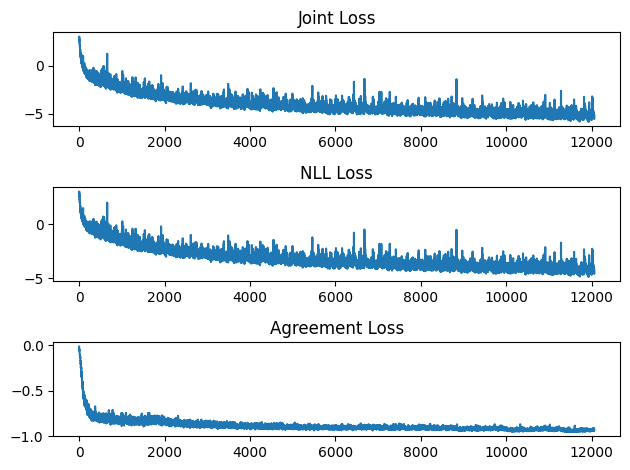

In [39]:
plt.subplot(3, 1, 1)
plt.plot(total_losses)
plt.title("Joint Loss")

plt.subplot(3, 1, 2)
plt.plot(nll_losses)
plt.title("NLL Loss")

plt.subplot(3, 1, 3)
plt.plot(simsam_losses)
plt.title("Agreement Loss")

plt.tight_layout()
plt.show()

In [41]:
_ = model.eval()

In [57]:
with torch.no_grad():
    _, _, _, _, ecg_reg, ppg_reg = model(test_ecg.to(device), test_ppg.to(device))

In [68]:
torch.abs(unnormalize_labels(ppg_reg[:, 0].cpu()) - test_labels[:, 0]).mean()

tensor(21.1856)

In [69]:
torch.abs(unnormalize_labels(ecg_reg[:, 0].cpu()) - test_labels[:, 0]).mean()

tensor(3.6625)